# Read CMIP-PPE data and emulate with Gaussian Processor


**Adjusted for the eScience course from Duncan Watson-Parris' example here: [gist.github.com/duncanwp](https://gist.github.com/duncanwp/89175a17b7221e4d3639765621c7f7f9)**

You have to use the env:ml-notebook to run this example.  

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
from esem import gp_model
from esem.utils import validation_plot, get_param_mask
from pathlib import Path
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime
import seaborn as sns

In [10]:
def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

def get_ensemble_member(ds):
    fname = ds.encoding['source']
    member = int(fname.split('.')[-4])
    return ds.assign_coords(member=member).expand_dims('member')

## Open the overview over the parameters in the CAM6 CESM PPE

In [11]:
data_path = Path('~/shared-craas1-ns9989k-ns9560k/CAM6_CESM_PPE/')

params = (xr.open_dataset(data_path / "parameter_262_w_control.nc")
          .to_pandas()
          .drop(columns = ['Sample_nmb'])
         )


### Open CMIP6 online catalog

In [12]:
cat_url = '/mnt/craas1-ns9989k-geo4992/data/catalogs/cesm-ppe.json'
col = intake.open_esm_datastore(cat_url)
col

,unique
experiment,1
ensemble,262
frequency,2
variable,124
units,27
long_name,124
vertical_levels,3
start_time,2
end_time,3
time_range,3



### Search corresponding data 

Please check [here](https://pangeo-data.github.io/escience-2022/pangeo101/data_discovery.html?highlight=cmip6) for info about CMIP and variables :) 

Particularly useful is maybe the variable search which you find here: https://clipc-services.ceda.ac.uk/dreq/mipVars.html 

In [13]:
cat = col.search(
    experiment=['present-day'], 
    variable = ['SWCF'], 
    frequency='monthly'
)

cat.df


,experiment,ensemble,frequency,variable,units,long_name,vertical_levels,start_time,end_time,time_range,path
0,present-day,0.0,monthly,SWCF,W/m2,Shortwave cloud forcing,1.0,0001-01-16,0003-12-16,0001-01-16-0003-12-16,/mnt/craas1-ns9989k-ns9560k/CAM6_CESM_PPE/PD/m...
1,present-day,1.0,monthly,SWCF,W/m2,Shortwave cloud forcing,1.0,0001-01-16,0003-12-16,0001-01-16-0003-12-16,/mnt/craas1-ns9989k-ns9560k/CAM6_CESM_PPE/PD/m...
2,present-day,2.0,monthly,SWCF,W/m2,Shortwave cloud forcing,1.0,0001-01-16,0003-12-16,0001-01-16-0003-12-16,/mnt/craas1-ns9989k-ns9560k/CAM6_CESM_PPE/PD/m...
3,present-day,3.0,monthly,SWCF,W/m2,Shortwave cloud forcing,1.0,0001-01-16,0003-12-16,0001-01-16-0003-12-16,/mnt/craas1-ns9989k-ns9560k/CAM6_CESM_PPE/PD/m...
4,present-day,4.0,monthly,SWCF,W/m2,Shortwave cloud forcing,1.0,0001-01-16,0003-12-16,0001-01-16-0003-12-16,/mnt/craas1-ns9989k-ns9560k/CAM6_CESM_PPE/PD/m...
...,...,...,...,...,...,...,...,...,...,...,...
257,present-day,258.0,monthly,SWCF,W/m2,Shortwave cloud forcing,1.0,0001-01-16,0003-12-16,0001-01-16-0003-12-16,/mnt/craas1-ns9989k-ns9560k/CAM6_CESM_PPE/PD/m...
258,present-day,259.0,monthly,SWCF,W/m2,Shortwave cloud forcing,1.0,0001-01-16,0003-12-16,0001-01-16-0003-12-16,/mnt/craas1-ns9989k-ns9560k/CAM6_CESM_PPE/PD/m...
259,present-day,260.0,monthly,SWCF,W/m2,Shortwave cloud forcing,1.0,0001-01-16,0003-12-16,0001-01-16-0003-12-16,/mnt/craas1-ns9989k-ns9560k/CAM6_CESM_PPE/PD/m...
260,present-day,261.0,monthly,SWCF,W/m2,Shortwave cloud forcing,1.0,0001-01-16,0003-12-16,0001-01-16-0003-12-16,/mnt/craas1-ns9989k-ns9560k/CAM6_CESM_PPE/PD/m...


In [14]:
cat.df['variable'].unique()

array(['SWCF'], dtype=object)

### Create dictionary from the list of datasets we found
- This step may take several minutes so be patient!

In [15]:
dset_dict = cat.to_dataset_dict()#preprocess = get_ensemble_member,)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.frequency'


In [16]:
dset_dict['present-day.monthly']

<xarray.Dataset> Size: 2GB
Dimensions:   (lat: 192, lon: 288, time: 36, ensemble: 262)
Coordinates:
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time      (time) object 288B 0001-01-16 12:00:00 ... 0003-12-16 12:00:00
  * ensemble  (ensemble) float64 2kB 0.0 1.0 2.0 3.0 ... 259.0 260.0 261.0 262.0
Data variables:
    SWCF      (ensemble, time, lat, lon) float32 2GB dask.array<chunksize=(1, 36, 192, 288), meta=np.ndarray>
Attributes:
    intake_esm_vars:                   ['SWCF']
    intake_esm_attrs:experiment:       present-day
    intake_esm_attrs:frequency:        monthly
    intake_esm_attrs:variable:         SWCF
    intake_esm_attrs:units:            W/m2
    intake_esm_attrs:long_name:        Shortwave cloud forcing
    intake_esm_attrs:vertical_levels:  1.0
    intake_esm_attrs:start_time:       0001-01-16
    intake_esm_attrs:end_time:         0003-12-16
    intake_esm_attrs:time_range:       0001-01-16-0003-12-16
    intake_esm_attrs:_data_format_:    netcdf
    intake_esm_dataset_key:            present-day.monthly

In [17]:
ds = dset_dict['present-day.monthly']
SWCF = global_mean(ds['SWCF']).mean('time').compute()

In [18]:
# Some of the PPE ensemble members are missing data so just select the params we actually have
sub_params = params.iloc[SWCF.ensemble.values]
# Unit normalise all the parameters
ppe_params = (sub_params - sub_params.min()) / (sub_params.max() - sub_params.min())

In [19]:
# We can use an information criterion to choose the best parameters automatically:
best_params = ppe_params[ppe_params.columns[get_param_mask(ppe_params, SWCF)]]
best_params.columns

/opt/conda/envs/ml-notebook/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.397e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/opt/conda/envs/ml-notebook/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.975e-01, with an active set of 20 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/opt/conda/envs/ml-notebook/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.077e-01, with an active set of 22 regr

Index(['micro_mg_autocon_nd_exp', 'micro_mg_dcs', 'cldfrc_dp1', 'cldfrc_dp2',
       'clubb_C6thlb', 'clubb_C8', 'clubb_c1', 'clubb_c11', 'clubb_c14',
       'dust_emis_fact', 'micro_mg_accre_enhan_fact', 'micro_mg_autocon_fact',
       'micro_mg_autocon_lwp_exp', 'micro_mg_berg_eff_factor',
       'micro_mg_homog_size', 'micro_mg_iaccr_factor', 'micro_mg_vtrmi_factor',
       'microp_aero_wsub_scale', 'microp_aero_wsubi_scale',
       'seasalt_emis_scale', 'zmconv_capelmt', 'zmconv_ke',
       'zmconv_tiedke_add'],
      dtype='object')

In [20]:
n_test = 25

X_test, X_train = best_params[:n_test], best_params[n_test:]
Y_test, Y_train = SWCF[:n_test], SWCF[n_test:]

## Global mean GP Model


In [21]:
# Can try different kernels here
gp = gp_model(X_train, Y_train, kernel=['Linear', 'RBF'])

In [22]:
gp.train()


In [23]:
m, v = gp.predict(X_test)


Proportion of 'Bad' estimates : 8.00%


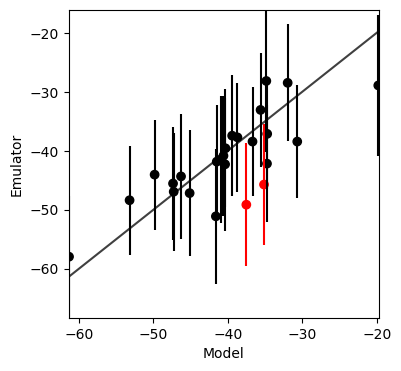

In [24]:
validation_plot(Y_test.data, m, v, figsize=(4,4))


## Calibrate

In [25]:
from esem.utils import get_random_params
from esem.abc_sampler import ABCSampler, constrain

In [26]:
X_train

,micro_mg_autocon_nd_exp,micro_mg_dcs,cldfrc_dp1,cldfrc_dp2,clubb_C6thlb,clubb_C8,clubb_c1,clubb_c11,clubb_c14,dust_emis_fact,...,micro_mg_berg_eff_factor,micro_mg_homog_size,micro_mg_iaccr_factor,micro_mg_vtrmi_factor,microp_aero_wsub_scale,microp_aero_wsubi_scale,seasalt_emis_scale,zmconv_capelmt,zmconv_ke,zmconv_tiedke_add
nmb_sim,,,,,,,,,,,,,,,,,,,,,
25,0.971500,0.805847,0.206424,0.671471,0.684229,0.793950,0.779754,0.227661,0.300534,0.974161,...,0.106340,0.556251,0.469144,0.505458,0.931798,0.049484,0.955314,0.074489,0.798951,0.634364
26,0.649866,0.894649,0.618148,0.938361,0.518324,0.538249,0.665506,0.812990,0.567041,0.865573,...,0.032305,0.301909,0.499515,0.088459,0.731500,0.092761,0.432079,0.058586,0.084965,0.833772
27,0.703768,0.767592,0.051199,0.348967,0.086444,0.549257,0.273296,0.979376,0.715680,0.107133,...,0.783043,0.644865,0.811843,0.905836,0.991289,0.268722,0.468469,0.823717,0.698678,0.404756
28,0.948312,0.000000,0.888282,0.481579,0.058440,0.964224,0.379381,0.530253,0.069777,0.730504,...,0.756368,0.749765,0.772850,0.655938,0.489364,0.415544,0.174367,0.469552,0.591195,0.371451
29,0.123560,0.365255,0.674939,0.979595,0.072070,0.271905,0.706585,0.654203,0.923545,0.517474,...,0.887158,0.438671,0.960535,0.433522,0.682204,0.255607,0.757154,0.702068,0.835647,0.854877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0.725604,0.924849,0.092477,0.631673,0.705486,0.747839,0.605231,0.586143,0.377838,0.898157,...,0.357568,0.320785,0.139384,0.989630,0.379718,0.667079,0.751509,0.923623,0.522542,0.081568
259,0.633606,0.341112,0.076788,0.264890,0.977408,0.668325,0.017842,0.878602,0.976971,0.009132,...,0.971503,0.063019,0.132357,0.034985,0.057183,0.494946,0.397352,0.818635,0.491236,0.056177
260,0.619860,0.568149,0.765996,0.915039,0.338742,0.983273,0.243526,0.099371,0.314178,0.179294,...,0.693411,0.448854,0.205011,0.371056,0.273651,0.185371,0.772156,0.323095,0.959486,0.484692


In [27]:
# Setup sampler with 1 million points
sample_points = pd.DataFrame(data=get_random_params(23, int(1e6)), columns=X_train.columns)
sampler = ABCSampler(gp, np.asarray([-40.5]), obs_uncertainty=0.5)

In [28]:
valid_samples = sampler.batch_constrain(sample_points, batch_size=10000)


  0%|          | 0/1000000 [00:00<?, ?sample/s]

In [29]:
print("Remaining points: {}".format(valid_samples.sum()))


Remaining points: 100


In [30]:
type(valid_samples)

numpy.ndarray